# Importing

## Relevant Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
sb.set()

## Importing relevant data 

In [3]:
# each row shows per round results
demo_df = pd.read_csv("dataset/esea_meta_demos.part1.csv")

# shows each encounter when damage is taken
dmg_df = pd.read_csv("dataset/esea_master_dmg_demos.part1.csv")

# shows each kill (regardless of current hp)
kill_df = pd.read_csv("dataset/esea_master_kills_demos.part1.csv")

# each map has xy value corresponding to coordinates in dmg_df
# convert df to dict for easy access
map_df = pd.read_csv("dataset/map_data.csv").rename(columns={'Unnamed: 0':'map_name'})
map_dict = map_df.set_index("map_name").transpose().to_dict()

___

# Data Cleaning

In [4]:
display(demo_df.head())
display(dmg_df.head())
display(kill_df.head())

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y
0,esea_match_13770997.dem,1,14372,111.8476,World,Animal Style,None,CounterTerrorist,1,0,...,Unknown,Unkown,0,0,76561198055054795,0,0.0000,0.00000,0.0000,0.000000
1,esea_match_13770997.dem,1,15972,124.3761,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,18,9,...,USP,Pistol,76561198048742997,0,76561198082200410,0,-1499.6900,63.33829,-669.5558,-79.769570
2,esea_match_13770997.dem,1,16058,125.0495,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,100,0,...,USP,Pistol,76561198055054795,0,76561197961009213,0,-1066.8740,3.44563,-614.1868,-91.707770
3,esea_match_13770997.dem,1,16066,125.1121,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,12,7,...,Glock,Pistol,76561198082200410,0,76561198055054795,0,-747.3146,-49.32681,-1065.5560,9.381622
4,esea_match_13770997.dem,1,16108,125.4410,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,15,7,...,USP,Pistol,76561198048742997,0,76561198082200410,0,-1501.8610,49.19798,-748.4188,-53.469220


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
0,esea_match_13770997.dem,1,16058,30.74165,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
1,esea_match_13770997.dem,1,16210,31.93185,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,4,4,False
2,esea_match_13770997.dem,1,16510,34.28094,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,3,4,False
3,esea_match_13770997.dem,1,17104,38.93212,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,3,3,False
4,esea_match_13770997.dem,1,17338,40.76441,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,2,3,False


In [5]:
display(demo_df.columns)
display(dmg_df.columns)
display(kill_df.columns)

Index(['file', 'map', 'round', 'start_seconds', 'end_seconds', 'winner_team',
       'winner_side', 'round_type', 'ct_eq_val', 't_eq_val'],
      dtype='object')

Index(['file', 'round', 'tick', 'seconds', 'att_team', 'vic_team', 'att_side',
       'vic_side', 'hp_dmg', 'arm_dmg', 'is_bomb_planted', 'bomb_site',
       'hitbox', 'wp', 'wp_type', 'att_id', 'att_rank', 'vic_id', 'vic_rank',
       'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y'],
      dtype='object')

Index(['file', 'round', 'tick', 'seconds', 'att_team', 'vic_team', 'att_side',
       'vic_side', 'wp', 'wp_type', 'ct_alive', 't_alive', 'is_bomb_planted'],
      dtype='object')

In [6]:
print(len(demo_df))
print(len(dmg_df))
print(len(kill_df))

215919
5992097
1569477


Add <b>round_duration</b> by subtracting end-start seconds. We also subtract 15 seconds, which is the intial buy time (to buy equipment) at the start of each round.

In [7]:
demo_updated_df = demo_df.assign(round_duration=lambda x: x.end_seconds - x.start_seconds - 15) # 15 seconds is the buying time each round is given
demo_updated_df.head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250,51.65128
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400,103.44070
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250,46.60860
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400,79.41750
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550,33.81390


Add <b>loser_side, t_win and ct_win </b> for easier manipulation of data onwards.

In [8]:
demo_updated_df['loser_side'] = np.where(demo_updated_df['winner_side']== 'Terrorist', 'CounterTerrorist', 'Terrorist')
demo_updated_df['t_win'] = np.where(demo_updated_df['winner_side']== 'Terrorist', True, False)
demo_updated_df['ct_win'] = np.where(demo_updated_df['winner_side']== 'CounterTerrorist', True, False)
demo_updated_df.head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250,51.65128,CounterTerrorist,True,False
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400,103.44070,CounterTerrorist,True,False
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250,46.60860,CounterTerrorist,True,False
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400,79.41750,CounterTerrorist,True,False
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550,33.81390,Terrorist,False,True


Remove relevant <b>null</b> values.

In [9]:
demo_updated_df.isnull().sum()

file               0
map                0
round              0
start_seconds     20
end_seconds       20
winner_team        1
winner_side        0
round_type         0
ct_eq_val          0
t_eq_val           0
round_duration    20
loser_side         0
t_win              0
ct_win             0
dtype: int64

In [10]:
demo_updated_df = demo_updated_df[~demo_updated_df['start_seconds'].isnull()]
demo_updated_df.isnull().sum()

file              0
map               0
round             0
start_seconds     0
end_seconds       0
winner_team       1
winner_side       0
round_type        0
ct_eq_val         0
t_eq_val          0
round_duration    0
loser_side        0
t_win             0
ct_win            0
dtype: int64

Some matches has <b>missing rounds</b>, so we <b>remove them</b>.

In [11]:
demo_updated_df[demo_updated_df['file']=='esea_match_13770997.dem'].tail() # 25 rounds, but only 23 rows

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
19,esea_match_13770997.dem,de_overpass,21,1786.007,1844.938,Hentai Hooligans,CounterTerrorist,NORMAL,31450,26300,43.931,Terrorist,False,True
20,esea_match_13770997.dem,de_overpass,22,1844.938,1999.946,Animal Style,Terrorist,NORMAL,30200,22050,140.008,CounterTerrorist,True,False
21,esea_match_13770997.dem,de_overpass,23,1999.946,2100.158,Hentai Hooligans,CounterTerrorist,NORMAL,18200,29300,85.212,Terrorist,False,True
22,esea_match_13770997.dem,de_overpass,24,2100.158,2157.930,Hentai Hooligans,CounterTerrorist,FORCE_BUY,29100,16150,42.772,Terrorist,False,True
23,esea_match_13770997.dem,de_overpass,25,2157.930,2207.949,Hentai Hooligans,CounterTerrorist,SEMI_ECO,27800,10900,35.019,Terrorist,False,True


In [12]:
file_unique = demo_updated_df['file'].unique() 
incomplete_matches = []

# put every match in a list that does not have a complete set of rounds by comparing difference in index and round of min and max
for file_name in file_unique:
    max_id = demo_updated_df.file.values.searchsorted(file_name, side='right')
    min_id = demo_updated_df.file.values.searchsorted(file_name, side='left')
    expected_total_rounds = max_id-min_id
    actual_rounds = demo_updated_df.iloc[max_id-1]['round']

    if (actual_rounds!=expected_total_rounds):
        incomplete_matches.append(file_name)

# remove incomplete matches
demo_clean_df = demo_updated_df[~demo_updated_df['file'].isin(incomplete_matches)]
dmg_clean_df = dmg_df[~dmg_df['file'].isin(incomplete_matches)]
kill_clean_df = kill_df[~kill_df['file'].isin(incomplete_matches)]

In [13]:
display(demo_clean_df.head())
display(dmg_clean_df.head())
display(kill_clean_df.head())

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
24,esea_match_13779704.dem,de_cache,1,131.2592,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
25,esea_match_13779704.dem,de_cache,2,188.1189,274.7697,Team 2,Terrorist,ECO,18450,5300,71.6508,CounterTerrorist,True,False
26,esea_match_13779704.dem,de_cache,3,274.7697,348.5590,Team 2,Terrorist,SEMI_ECO,9550,22900,58.7893,CounterTerrorist,True,False
27,esea_match_13779704.dem,de_cache,4,348.5590,419.6258,Team 2,Terrorist,ECO,1600,19650,56.0668,CounterTerrorist,True,False
28,esea_match_13779704.dem,de_cache,5,419.6258,487.9857,Team 1,CounterTerrorist,NORMAL,23350,21750,53.3599,Terrorist,False,True


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y
759,esea_match_13779704.dem,1,20759,161.8639,Team 1,Team 2,CounterTerrorist,Terrorist,15,7,...,USP,Pistol,76561198078736000,0,76561198371993258,0,-170.91130,2002.935,511.5505,1678.621
760,esea_match_13779704.dem,1,20961,163.4442,Team 1,Team 2,CounterTerrorist,Terrorist,31,0,...,USP,Pistol,76561198078736000,0,76561197962264927,0,-256.35050,1958.900,357.7615,1831.760
761,esea_match_13779704.dem,1,21001,163.7572,Team 2,Team 1,Terrorist,CounterTerrorist,11,6,...,Glock,Pistol,76561197962264927,0,76561198078736000,0,348.90870,1830.443,-267.8188,1902.607
762,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,USP,Pistol,76561198242564394,0,76561198371993258,0,55.05295,1413.524,187.1718,1951.511
763,esea_match_13779704.dem,1,21179,165.1497,Team 1,Team 2,CounterTerrorist,Terrorist,32,0,...,USP,Pistol,76561198242564394,0,76561197962264927,0,68.18559,1411.809,275.8283,1780.951


,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
184,esea_match_13779704.dem,1,21093,33.21770,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
185,esea_match_13779704.dem,1,21251,34.45378,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,5,3,False
186,esea_match_13779704.dem,1,21341,35.15788,Team 2,Team 1,Terrorist,CounterTerrorist,Glock,Pistol,4,3,False
187,esea_match_13779704.dem,1,21883,39.39810,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,4,2,False
188,esea_match_13779704.dem,1,23091,48.84865,Team 1,Team 2,CounterTerrorist,Terrorist,USP,Pistol,4,1,False


<b>Merge all dataframes</b> into one big dataframe (to add their columns together).

In [14]:
# add the unique columns of dmg_clean_df to kill_clean_df
kill_confirm_df = dmg_clean_df.merge(kill_clean_df, how='inner', on=['file','tick'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)').drop(columns=['att_rank','vic_rank'])
kill_confirm_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,wp,wp_type,att_id,vic_id,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,ct_alive,t_alive
0,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,USP,Pistol,76561198242564394,76561198371993258,55.05295,1413.524,187.1718,1951.511,5,4
1,esea_match_13779704.dem,1,21251,165.7130,Team 1,Team 2,CounterTerrorist,Terrorist,37,0,...,USP,Pistol,76561198242564394,76561197962264927,60.15099,1415.707,242.1282,1770.468,5,3
2,esea_match_13779704.dem,1,21341,166.4171,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,Glock,Pistol,76561198168699127,76561198242564394,184.84450,1324.460,124.2944,1342.035,4,3
3,esea_match_13779704.dem,1,21883,170.6573,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,USP,Pistol,76561198078736000,76561198121398598,-264.34310,2235.892,600.5919,1621.023,4,2
4,esea_match_13779704.dem,1,23091,180.1078,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,USP,Pistol,76561198235034756,76561198168699127,-929.91270,1230.132,379.8438,1429.177,4,1


In [15]:
# add unique columns of kill_confirm_df to demo_clean_df
cleaned_df = kill_confirm_df.merge(demo_clean_df, how='inner', on=['file','round'], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
cleaned_df.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
0,esea_match_13779704.dem,1,21093,164.4769,Team 1,Team 2,CounterTerrorist,Terrorist,85,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
1,esea_match_13779704.dem,1,21251,165.7130,Team 1,Team 2,CounterTerrorist,Terrorist,37,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
2,esea_match_13779704.dem,1,21341,166.4171,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
3,esea_match_13779704.dem,1,21883,170.6573,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
4,esea_match_13779704.dem,1,23091,180.1078,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,188.1189,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True


In [16]:
cleaned_df.columns

Index(['file', 'round', 'tick', 'seconds', 'att_team', 'vic_team', 'att_side',
       'vic_side', 'hp_dmg', 'arm_dmg', 'is_bomb_planted', 'bomb_site',
       'hitbox', 'wp', 'wp_type', 'att_id', 'vic_id', 'att_pos_x', 'att_pos_y',
       'vic_pos_x', 'vic_pos_y', 'ct_alive', 't_alive', 'map', 'start_seconds',
       'end_seconds', 'winner_team', 'winner_side', 'round_type', 'ct_eq_val',
       't_eq_val', 'round_duration', 'loser_side', 't_win', 'ct_win'],
      dtype='object')

In [17]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309137 entries, 0 to 1309136
Data columns (total 35 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   file             1309137 non-null  object 
 1   round            1309137 non-null  int64  
 2   tick             1309137 non-null  int64  
 3   seconds          1309137 non-null  float64
 4   att_team         1309137 non-null  object 
 5   vic_team         1309137 non-null  object 
 6   att_side         1309137 non-null  object 
 7   vic_side         1309137 non-null  object 
 8   hp_dmg           1309137 non-null  int64  
 9   arm_dmg          1309137 non-null  int64  
 10  is_bomb_planted  1309137 non-null  bool   
 11  bomb_site        221532 non-null   object 
 12  hitbox           1309137 non-null  object 
 13  wp               1309137 non-null  object 
 14  wp_type          1309137 non-null  object 
 15  att_id           1309137 non-null  int64  
 16  vic_id           1

In [18]:
cleaned_df.isnull().sum()

file                     0
round                    0
tick                     0
seconds                  0
att_team                 0
vic_team                 0
att_side                 0
vic_side                 0
hp_dmg                   0
arm_dmg                  0
is_bomb_planted          0
bomb_site          1087605
hitbox                   0
wp                       0
wp_type                  0
att_id                   0
vic_id                   0
att_pos_x                0
att_pos_y                0
vic_pos_x                0
vic_pos_y                0
ct_alive                 0
t_alive                  0
map                      0
start_seconds            0
end_seconds              0
winner_team              0
winner_side              0
round_type               0
ct_eq_val                0
t_eq_val                 0
round_duration           0
loser_side               0
t_win                    0
ct_win                   0
dtype: int64

<b>Export clean dataset</b> for use in other notebooks.

In [19]:
#cleaned_df.to_csv("dataset/clean.csv")

Drop rows and columns to make a <b>new dataframe</b> that shows the <b>round-end stats</b>.

In [20]:
round_end_stats_df = cleaned_df.drop_duplicates(keep='last',subset=['file','round']).drop(columns=['hitbox','wp','wp_type','att_pos_x','att_pos_y','vic_pos_x','vic_pos_y','arm_dmg','hp_dmg','start_seconds','end_seconds','vic_id','att_id','att_team','vic_team','att_side','vic_side','tick','seconds'])
round_end_stats_df.head()

,file,round,is_bomb_planted,bomb_site,ct_alive,t_alive,map,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
5,esea_match_13779704.dem,1,False,NaN,4,0,de_cache,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
14,esea_match_13779704.dem,2,False,NaN,0,1,de_cache,Team 2,Terrorist,ECO,18450,5300,71.6508,CounterTerrorist,True,False
22,esea_match_13779704.dem,3,True,B,0,3,de_cache,Team 2,Terrorist,SEMI_ECO,9550,22900,58.7893,CounterTerrorist,True,False
28,esea_match_13779704.dem,4,True,A,0,4,de_cache,Team 2,Terrorist,ECO,1600,19650,56.0668,CounterTerrorist,True,False
35,esea_match_13779704.dem,5,False,NaN,3,0,de_cache,Team 1,CounterTerrorist,NORMAL,23350,21750,53.3599,Terrorist,False,True


In [21]:
round_end_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176768 entries, 5 to 1309136
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   file             176768 non-null  object 
 1   round            176768 non-null  int64  
 2   is_bomb_planted  176768 non-null  bool   
 3   bomb_site        82803 non-null   object 
 4   ct_alive         176768 non-null  int64  
 5   t_alive          176768 non-null  int64  
 6   map              176768 non-null  object 
 7   winner_team      176768 non-null  object 
 8   winner_side      176768 non-null  object 
 9   round_type       176768 non-null  object 
 10  ct_eq_val        176768 non-null  int64  
 11  t_eq_val         176768 non-null  int64  
 12  round_duration   176768 non-null  float64
 13  loser_side       176768 non-null  object 
 14  t_win            176768 non-null  bool   
 15  ct_win           176768 non-null  bool   
dtypes: bool(3), float64(1), int64(5), obj

Replace <b>NA</b> in <b>bomb_site</b> column to something more meaningful - "<b>Not Planted</b>".

In [22]:
round_end_stats_df.isnull().sum()

file                   0
round                  0
is_bomb_planted        0
bomb_site          93965
ct_alive               0
t_alive                0
map                    0
winner_team            0
winner_side            0
round_type             0
ct_eq_val              0
t_eq_val               0
round_duration         0
loser_side             0
t_win                  0
ct_win                 0
dtype: int64

In [23]:
round_end_stats_df['bomb_site'].fillna('Not Planted', inplace = True)
round_end_stats_df

,file,round,is_bomb_planted,bomb_site,ct_alive,t_alive,map,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
5,esea_match_13779704.dem,1,False,Not Planted,4,0,de_cache,Team 1,CounterTerrorist,PISTOL_ROUND,4550,3850,41.8597,Terrorist,False,True
14,esea_match_13779704.dem,2,False,Not Planted,0,1,de_cache,Team 2,Terrorist,ECO,18450,5300,71.6508,CounterTerrorist,True,False
22,esea_match_13779704.dem,3,True,B,0,3,de_cache,Team 2,Terrorist,SEMI_ECO,9550,22900,58.7893,CounterTerrorist,True,False
28,esea_match_13779704.dem,4,True,A,0,4,de_cache,Team 2,Terrorist,ECO,1600,19650,56.0668,CounterTerrorist,True,False
35,esea_match_13779704.dem,5,False,Not Planted,3,0,de_cache,Team 1,CounterTerrorist,NORMAL,23350,21750,53.3599,Terrorist,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309095,esea_match_13793043.dem,14,True,A,0,3,de_cache,Team 2,Terrorist,NORMAL,28400,25800,51.0850,CounterTerrorist,True,False
1309101,esea_match_13793043.dem,15,False,Not Planted,4,0,de_cache,Team 1,CounterTerrorist,FORCE_BUY,13150,25550,41.8700,Terrorist,False,True
1309110,esea_match_13793043.dem,16,False,Not Planted,2,0,de_cache,Team 2,CounterTerrorist,PISTOL_ROUND,4200,4250,52.3360,Terrorist,False,True
1309117,esea_match_13793043.dem,17,False,Not Planted,4,0,de_cache,Team 2,CounterTerrorist,SEMI_ECO,18300,8200,38.9760,Terrorist,False,True


<b>Export round-end stats dataset</b> for use in other notebooks.

In [24]:
#round_end_stats_df.to_csv("dataset/round_end_stats.csv")

# EDA & Data Representation

### Separating dataset based on their map locations.

In [25]:
#seperate df based on maps
df_cleaned_sep_df = {}
df_round_end_sep_df = {}

for map_name in map_dict.keys():
    df_cleaned_sep_df[map_name] = cleaned_df[cleaned_df['map']==map_name] 
    df_round_end_sep_df[map_name] = round_end_stats_df[round_end_stats_df['map']==map_name] 


In [26]:
display(df_cleaned_sep_df['de_train'].head())
display(df_round_end_sep_df['de_train'].head())

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,...,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
2320,esea_match_13779798.dem,1,20446,159.3297,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,49.6245,CounterTerrorist,True,False
2321,esea_match_13779798.dem,1,21388,166.7050,Team 2,Team 1,Terrorist,CounterTerrorist,64,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,49.6245,CounterTerrorist,True,False
2322,esea_match_13779798.dem,1,21636,168.6467,Team 2,Team 1,Terrorist,CounterTerrorist,100,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,49.6245,CounterTerrorist,True,False
2323,esea_match_13779798.dem,1,22352,174.2526,Team 1,Team 2,CounterTerrorist,Terrorist,67,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,49.6245,CounterTerrorist,True,False
2324,esea_match_13779798.dem,1,22658,176.6484,Team 1,Team 2,CounterTerrorist,Terrorist,100,0,...,196.2378,Team 2,Terrorist,PISTOL_ROUND,3250,3650,49.6245,CounterTerrorist,True,False


,file,round,is_bomb_planted,bomb_site,ct_alive,t_alive,map,winner_team,winner_side,round_type,ct_eq_val,t_eq_val,round_duration,loser_side,t_win,ct_win
2328,esea_match_13779798.dem,1,True,A,0,1,de_train,Team 2,Terrorist,PISTOL_ROUND,3250,3650,49.6245,CounterTerrorist,True,False
2336,esea_match_13779798.dem,2,True,B,0,2,de_train,Team 2,Terrorist,ECO,3150,13050,59.6774,CounterTerrorist,True,False
2341,esea_match_13779798.dem,3,True,A,0,5,de_train,Team 2,Terrorist,ECO,1600,22900,42.6406,CounterTerrorist,True,False
2349,esea_match_13779798.dem,4,False,Not Planted,3,0,de_train,Team 1,CounterTerrorist,NORMAL,26050,26450,55.9193,Terrorist,False,True
2357,esea_match_13779798.dem,5,False,Not Planted,2,0,de_train,Team 1,CounterTerrorist,NORMAL,30500,21500,71.5312,Terrorist,False,True


___

### Lists to be used with <i>interact</i> function

In [27]:
maps = list(df_cleaned_sep_df.keys())

sides = ['Both', 'CounterTerrorist', 'Terrorist']

weapons = list(cleaned_df['wp'].unique())
weapons.remove('Unknown')
weapons.insert(0,'ALL')

wp_type = list(cleaned_df['wp_type'].unique())
wp_type.remove('Unkown')

eco_type = ['BOTH','ECO','SEMI_ECO']

all_maps = [False,True]

___

### Round Duration Stats

,round_duration
count,176768.000000
mean,72.769620
std,28.831504
min,14.731000
25%,52.688000
50%,69.039850
75%,88.373125
max,1116.185000


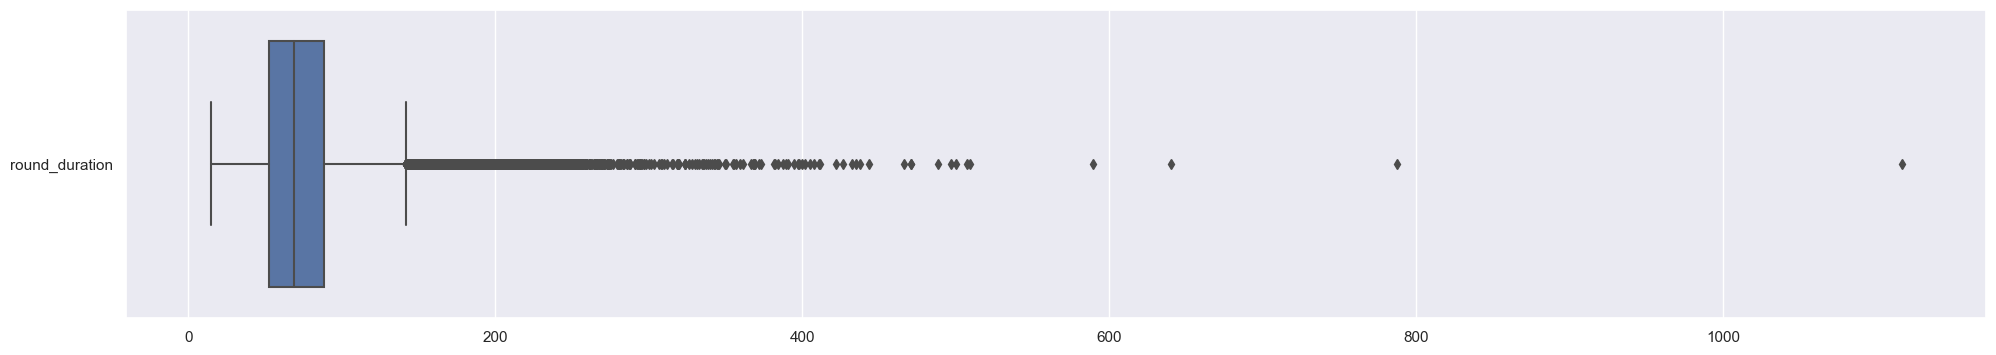

In [28]:
f = plt.figure(figsize=(24, 4))
rd = round_end_stats_df[['round_duration']]
sb.boxplot(data = rd, orient = "h")
rd.describe()

We see that there's a lot of outliers. We realise that the round duration includes the timeout for each game. A timeout is called when there is a technical issue with one of the players. We remove these rounds that used a timeout.


In [29]:
def remove_outliers(df,key):
    q1 = df[key].quantile(q=0.25)
    q3 = df[key].quantile(q=0.75)
    iqr = q3-q1
    leftOutlier = q1-1.5*iqr
    rightOutlier = q3+1.5*iqr
    df_filtered = df[(df[key] < rightOutlier) & (df[key] > leftOutlier)]
    return df_filtered

,round_duration
count,174379.000000
mean,71.101416
std,24.338956
min,14.731000
25%,52.449850
50%,68.555000
75%,87.407300
max,141.899000


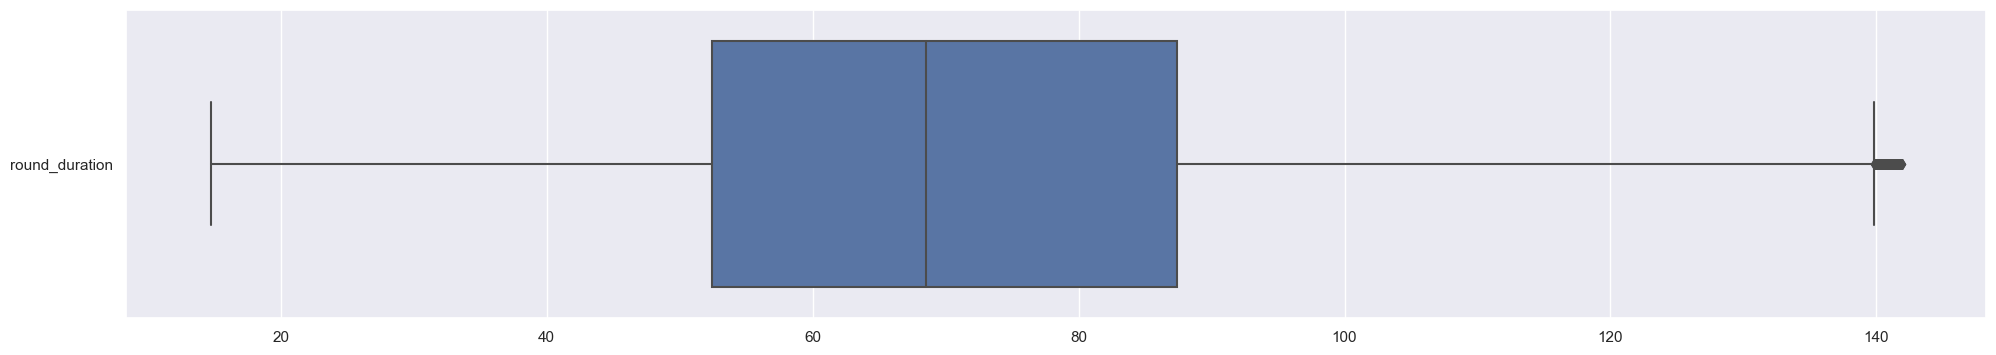

In [30]:
rd_no_outliers = remove_outliers(rd,'round_duration')
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = rd_no_outliers, orient = "h")
rd_no_outliers.describe()

After reducing the skew, we can see that the fastest round is about 15 seconds, with the longest being 142 seconds. On average, each round lasts 69 seconds.

___

### Likely Side to Win as time passes

<AxesSubplot:xlabel='round_duration', ylabel='Count'>

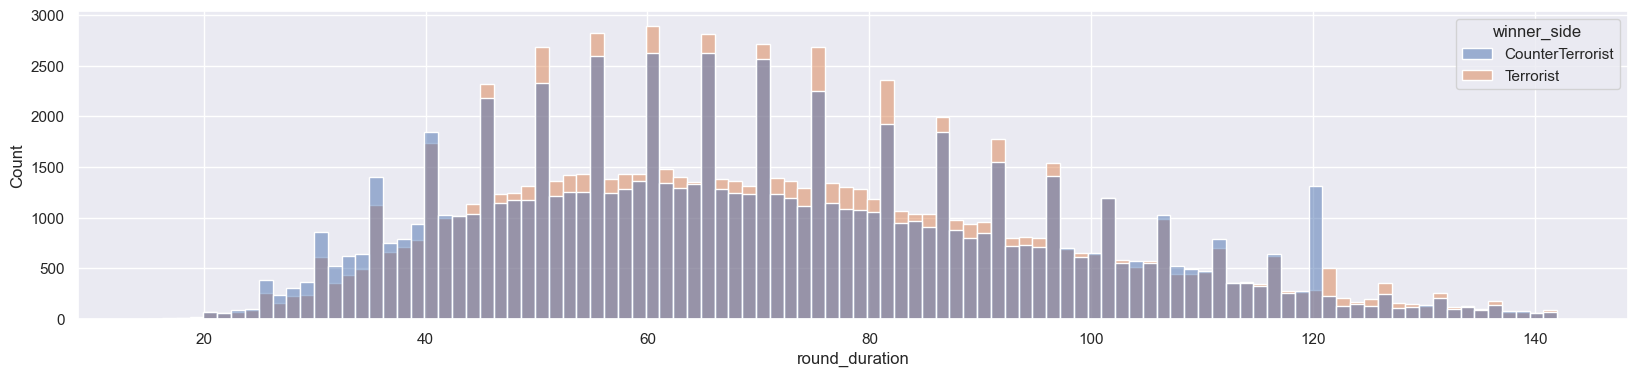

In [31]:
time_win = remove_outliers(round_end_stats_df[["winner_side","round_duration"]],'round_duration')
time_win['round_duration'] = time_win['round_duration'].round(decimals=0)
f = plt.figure(figsize=(20,4))
sb.histplot(data=time_win, x="round_duration", hue="winner_side")

Counter Terrorists are likely to win in the earlier time of the round, until about 40 seconds. </br>
Terrorists are then more likely to win from 40 seconds, all the way until about 100 seconds. </br>
Counter Terrorists then has a chance to win again from 100 seconds to 120 seconds.

___

### Likely Side to Win based on map

In [32]:
def side_to_win(Map):
    df = df_round_end_sep_df[Map]
    winner_side = df['winner_side']
    print(winner_side.value_counts().sort_index())
    sb.catplot(x='winner_side',data = df.sort_values('winner_side'), kind = "count")
    
    ct = winner_side.value_counts().sort_index()[0]
    t = winner_side.value_counts().sort_index()[1]
    diff = abs(ct-t)/(ct+t)*100
    
    print()
    if (ct<t):
        print("Terrorists are {}% likelier to win.".format(round(diff,2)))
    elif (ct>t):
        print("Counter-Terrorists are {}% likelier to win.".format(round(diff,2)))
    else:
        print("Both sides have equal chance at winning.")
        
    plt.show()
    print()

In [33]:
print("           _________________________")
print("          |                         |")
print("          |  --Select Parameters--  |")
print("          |_________________________|")
print("")

interact(side_to_win, Map = maps)

           _________________________
          |                         |
          |  --Select Parameters--  |
          |_________________________|



interactive(children=(Dropdown(description='Map', options=('de_cache', 'de_cbble', 'de_dust2', 'de_inferno', '…

<function __main__.side_to_win(Map)>

___

### Find out which bomb_site is better for a <i>Terrorist Team</i> to plant their bomb to win.

In [34]:
def bombplant(Map):
    df = df_round_end_sep_df[Map]
    df = df[['is_bomb_planted','t_win','bomb_site','ct_win']]
    bomb_planted_t_win = df[df['t_win']].sort_values(axis=0,by='bomb_site')
    
    print(bomb_planted_t_win['bomb_site'].value_counts().sort_index())
    a_plant = bomb_planted_t_win['bomb_site'].value_counts().sort_index()[0]
    b_plant = bomb_planted_t_win['bomb_site'].value_counts().sort_index()[1]
    diff = abs(a_plant-b_plant)/(a_plant+b_plant)*100
    
    print()
    if (a_plant>b_plant):
        print("Planting in Bombsite A has a {}% better chance at winning than planting at Bombsite B.".format(round(diff,2)))
    elif (a_plant<b_plant):
        print("Planting in Bombsite B has a {}% better chance at winning than planting at Bombsite A.".format(round(diff,2)))
    else:
        print("Both sides have equal chance at winning.")
  
    sb.catplot(y = "bomb_site", data = bomb_planted_t_win, kind = "count")
    plt.show()
    print()
 

In [35]:
print("           _________________________")
print("          |                         |")
print("          |  --Select Parameters--  |")
print("          |_________________________|")
print("")

interact(bombplant, Map = maps)

           _________________________
          |                         |
          |  --Select Parameters--  |
          |_________________________|



interactive(children=(Dropdown(description='Map', options=('de_cache', 'de_cbble', 'de_dust2', 'de_inferno', '…

<function __main__.bombplant(Map)>

___

### Eco vs Semi-Eco Win Rate

In [36]:
def eco_map(Map,eco_type):
    df_value = df_round_end_sep_df[Map]
        
    df_value =  df_value[['winner_side','ct_eq_val','t_eq_val','round_type']]
    df_value['eco_side'] = np.where(df_value['ct_eq_val']<df_value['t_eq_val'], 'CounterTerrorist', 'Terrorist')
    df_value['eco_win'] = np.where(df_value['winner_side']==df_value['eco_side'], True, False)
    
    if eco_type!='BOTH':
        df_eco = df_value[df_value['round_type']==eco_type]
    else:
        df_eco = df_value[df_value['round_type'].isin(['ECO','SEMI_ECO'])]
    
    df_eco = df_eco[['eco_side','eco_win']].sort_values(axis=0,by='eco_side')
    
    print(df_eco[['eco_side','eco_win']].value_counts().sort_index())
    
    eco_list = list(df_eco[['eco_side','eco_win']].value_counts().sort_index())
    
    ct_no_win = eco_list[0]
    ct_win = eco_list[1]
    ct_diff = round(abs(ct_win)/(ct_no_win+ct_win)*100,2)
    
    t_no_win = eco_list[2]
    t_win = eco_list[3]
    t_diff = round(abs(t_win)/(t_no_win+t_win)*100,2) 
    
    
    print()
    print("Counter Terrorists has a {}% chance of winning in {} rounds.".format(ct_diff,eco_type))
    print("Terrorists has a {}% chance of winning in {} rounds.".format(t_diff,eco_type))
    
    df_eco.describe()
    sb.catplot(y = "eco_side", data = df_eco, hue='eco_win', kind = "count", orient='h')

In [37]:
print("           _________________________")
print("          |                         |")
print("          |  --Select Parameters--  |")
print("          |_________________________|")
print("")

interact(eco_map, Map = maps, eco_type=eco_type)
import warnings
warnings.filterwarnings('ignore')

           _________________________
          |                         |
          |  --Select Parameters--  |
          |_________________________|



interactive(children=(Dropdown(description='Map', options=('de_cache', 'de_cbble', 'de_dust2', 'de_inferno', '…

We see that on average, teams has at least a <b>10% better chance of winning</b> if they decide to <b>semi-eco</b>, which is when 1 or 2 players buy guns and armor, rather than nobody buying anything (in an eco round).

___

### Scatter plot will be shown with respect to the map selected
#### Areas with a higher density should be avoided

In [38]:
def plotheat(Map,Team,Weapon):

    endx = map_dict[Map]['EndX']
    endy = map_dict[Map]['EndY']
    resx = map_dict[Map]['ResX']
    resy = map_dict[Map]['ResY']
    startx = map_dict[Map]['StartX']
    starty = map_dict[Map]['StartY']
    df = df_cleaned_sep_df[Map]
    if (Team != 'Both'):
        df = df[df['vic_side'] == Team]
    if (Weapon != 'ALL'):
        df = df[df['wp'] == Weapon]
    total_deaths = len(df)
    print("Total Deaths:{}".format(total_deaths))
    
    if (total_deaths<=10):
        size=10
    elif (total_deaths<=100):
        size=5
    elif (total_deaths<=500):
        size=1
    elif (total_deaths<=1000):
        size=0.1
    elif (total_deaths<=5000):
        size=0.03
    elif (total_deaths<=10000):
        size=0.05
    elif (total_deaths<=25000):
        size=0.01
    elif (total_deaths<=50000):
        size=0.002
    elif (total_deaths<=100000):
        size=0.0005
    else:
        size=0.00003
        
    
    im = plt.imread('maps/'+Map+'.png')
    plt.axis([startx, endx, starty, endy])
    if(Team != 'Both'):
        if(Team == 'Terrorist'):
            color='red'
        else:
            color='blue'
            
        plt.scatter(x=df.vic_pos_x, y=df.vic_pos_y, s=size, zorder=1, c=color)
    else:
        plt.scatter(x=df[df['vic_side'] == 'CounterTerrorist'].vic_pos_x, y=df[df['vic_side'] == 'CounterTerrorist'].vic_pos_y, s=size, zorder=1, c='blue')
        plt.scatter(x=df[df['vic_side'] == 'Terrorist'].vic_pos_x, y=df[df['vic_side'] == 'Terrorist'].vic_pos_y, s=size, zorder=1, c='red')
    #plt.scatter(x=df.att_pos_x, y=df.att_pos_y, s=size, zorder=1, c='red')
    plt.imshow(im, zorder=0, extent=[startx, endx, starty, endy])
    plt.axis('off')
    plt.show()
    

In [39]:
print("           _________________________")
print("          |                         |")
print("          |  --Select Parameters--  |")
print("          |_________________________|")
print("")
    
interact(plotheat, Map = maps, Team = sides, Weapon = weapons)

           _________________________
          |                         |
          |  --Select Parameters--  |
          |_________________________|



interactive(children=(Dropdown(description='Map', options=('de_cache', 'de_cbble', 'de_dust2', 'de_inferno', '…

<function __main__.plotheat(Map, Team, Weapon)>

___

### Most Used Weapons by each side

In [40]:
def weapon_stats(Wp_type):
    f = plt.figure(figsize=(20,10))
    df = cleaned_df[['wp_type','wp','att_side']]
    df = df[df['wp_type']==Wp_type].sort_values(axis=0,by='att_side')
    sb.histplot(data=df,x='wp',hue='att_side', stat='count')
    df['wp'].describe()

In [41]:
print("           _________________________")
print("          |                         |")
print("          |  --Select Parameters--  |")
print("          |_________________________|")
print("")

interact(weapon_stats, Wp_type = wp_type)

           _________________________
          |                         |
          |  --Select Parameters--  |
          |_________________________|



interactive(children=(Dropdown(description='Wp_type', options=('Pistol', 'SMG', 'Rifle', 'Sniper', 'Heavy', 'G…

<function __main__.weapon_stats(Wp_type)>

Weapons are droppped upon getting killed. Some weapons are also side-exclusive weapons. <br>
For example for the Terrorist side, pistols are the Glock and Tec9, rifles are AK-47 and Galil and SMG are Mac10. <br>
For the Counter-terrorist side, pistols are USP-S, FiveSeven and P200, rifles are M4 and M4A1 and SMG are MP9. <br>

If we look at the graph for <b>rifles</b>, we see that AK-47 is being used the most. Even for the CT side, where the only option to use it is to loot a Terrorist's dead body, is the second most-used rifle used by the CTs. This means that the AK-47 is a powerful rifle that both want to use.

For the Heavy weapons, we see that the kills are overwhelmingly CT-sided. Being a shorter-ranged and defensive weapon, CTs are capable of utilising it more to defend their bombsites.

___

# Machine Learning

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

sb.set()

In [43]:
#remove rounds with <= eq_val_diff of 5000
ml_df = pd.DataFrame(cleaned_df[abs(cleaned_df['ct_eq_val'] - cleaned_df['t_eq_val']) >= 5000])
ml_df = ml_df.sample(n=100000)

#response
side_win_ct = pd.DataFrame(ml_df['ct_win'])
side_win_t = pd.DataFrame(ml_df['t_win'])

#predictor
eq_diff_ct = pd.DataFrame({
    'eq_diff': ml_df['ct_eq_val'] - ml_df['t_eq_val'],
    'is_bomb_planted': ml_df['is_bomb_planted']
})
eq_diff_t = pd.DataFrame({
    'eq_diff': ml_df['t_eq_val'] - ml_df['ct_eq_val'],
    'is_bomb_planted': ml_df['is_bomb_planted']
})

#train test split
X_train, X_test, y_train, y_test = train_test_split(eq_diff_ct, side_win_ct, test_size = 0.20)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(eq_diff_t, side_win_t, test_size = 0.20)


# Legend
1. eq_diff : Total value of CT equipment - T equipment or T equipment - CT equipment depending on team
     * if -X  (Enemy team equipment cost X more)

     * if +X  (Your team equipment cost X more)
     
     
 
2. is_bomb_planted : Whether bomb is planted

## 1) Random Forest Classification

## Cross Validation

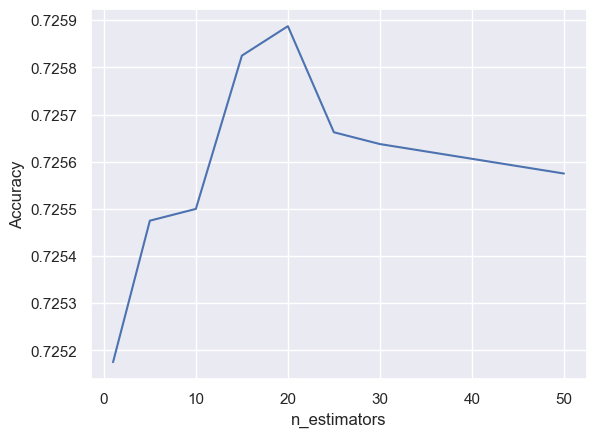

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

n_estimators_range = [1, 5, 10, 15, 20, 25, 30, 50] # define a range of values to test
cv_scores = []
for n in n_estimators_range:
    rfc = RandomForestClassifier(n_estimators=n, max_depth=4)
    scores = cross_val_score(rfc, X_train, y_train.values.ravel(), cv=10) # evaluate the model with 5-fold cross-validation
    cv_scores.append(np.mean(scores))

# plot the results
import matplotlib.pyplot as plt
plt.plot(n_estimators_range, cv_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

### As we can see with 20 decision trees a higher accuracy is obtained, hence we should use n_estimators value of 20

## Counter Terrorist

In [54]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20, max_depth=4)
rfc.fit(X_train, y_train.values.ravel())
rfc_train_pred = rfc.predict(X_train)
rfc_test_pred = rfc.predict(X_test)

print("Classification Accuracy Train\t:", rfc.score(X_train, y_train.values.ravel()))
print()
print("Classification Accuracy Test\t:", rfc.score(X_test, y_test.values.ravel()))
print()

acc_rfc = rfc.score(X_test, y_test.values.ravel())

Classification Accuracy Train	: 0.726225

Classification Accuracy Test	: 0.7193



## Terrorist

In [55]:
from sklearn.ensemble import RandomForestClassifier

rfc_t = RandomForestClassifier(n_estimators=20, max_depth=4)
rfc_t.fit(X_train_t, y_train_t.values.ravel())
rfc_train_t_pred = rfc.predict(X_train_t)
rfc_test_t_pred = rfc.predict(X_test_t)


print("Classification Accuracy Train\t:", rfc_t.score(X_train_t, y_train_t.values.ravel()))
print()

print("Classification Accuracy Test\t:", rfc_t.score(X_test_t, y_test_t.values.ravel()))
print() 

Classification Accuracy Train	: 0.7236375

Classification Accuracy Test	: 0.72805



 ## 1.1 Visualisation and model evaluation with Confusion Matrix 

## Counter Terrorist

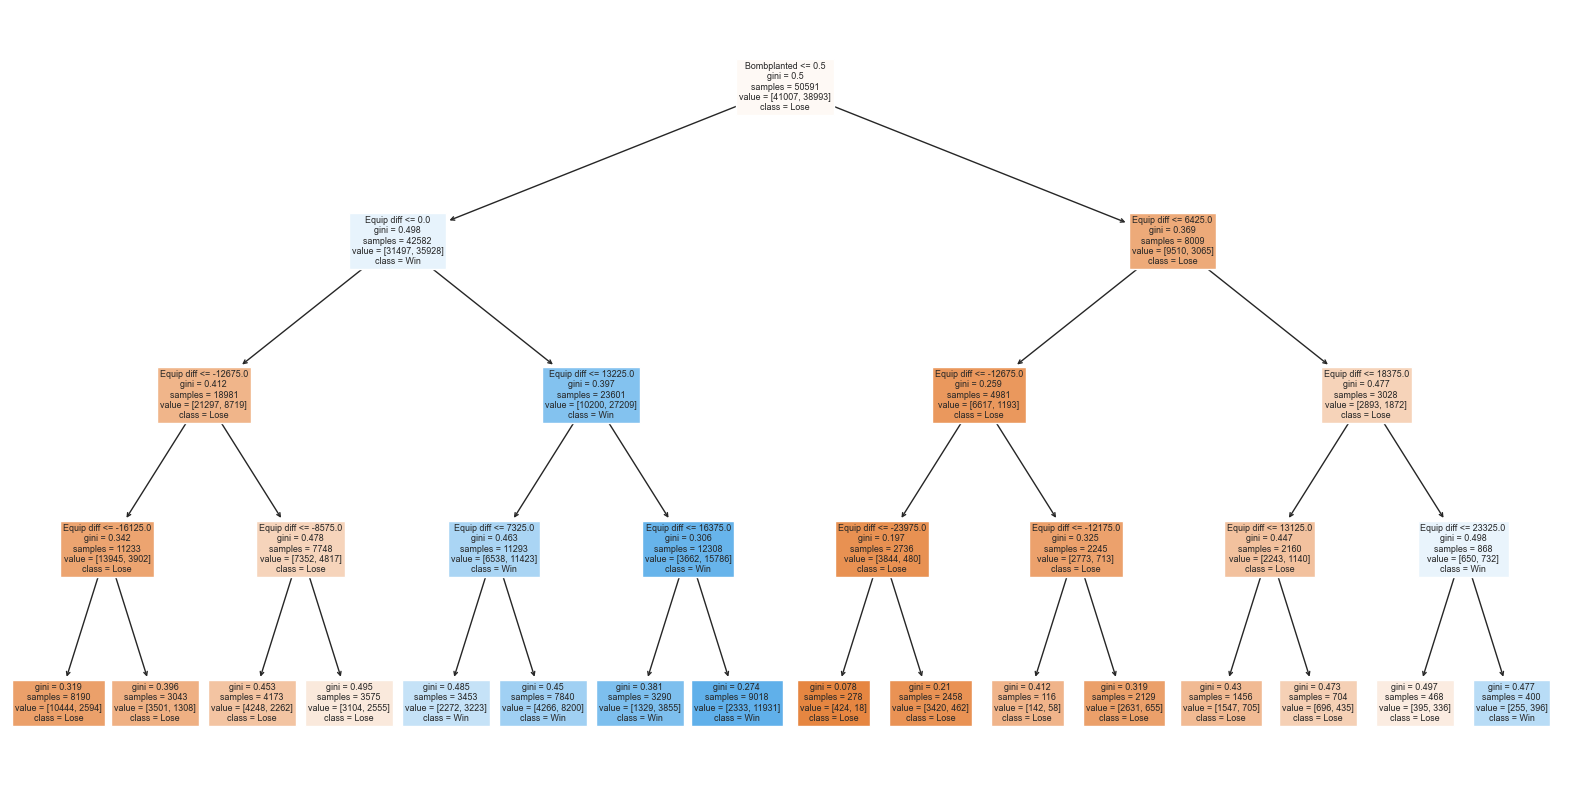

In [56]:
from sklearn.tree import plot_tree

# Plotting the first tree of the Random Forest Classifier
plt.figure(figsize=(20,10))
tree = plot_tree(rfc.estimators_[0], feature_names=['Equip diff','Bombplanted'], class_names=['Lose', 'Win'], filled=True)

In [57]:
from sklearn.metrics import classification_report

target_names = ['CT Lose', 'CT Win']
print(classification_report(y_test, rfc_test_pred, target_names=target_names))

              precision    recall  f1-score   support

     CT Lose       0.72      0.73      0.73     10264
      CT Win       0.71      0.71      0.71      9736

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



### Precision: 
Out of all the rounds where the model predicted a win, only 71% actually did.

### Recall: 
Out of all the rounds which are actually won, the model predicted this outcome correctly for 71% of the time.

### f1-score
We got a value of 0.72, which shows the accuracy of the model in predicting whether the round is won 

## Terrorist

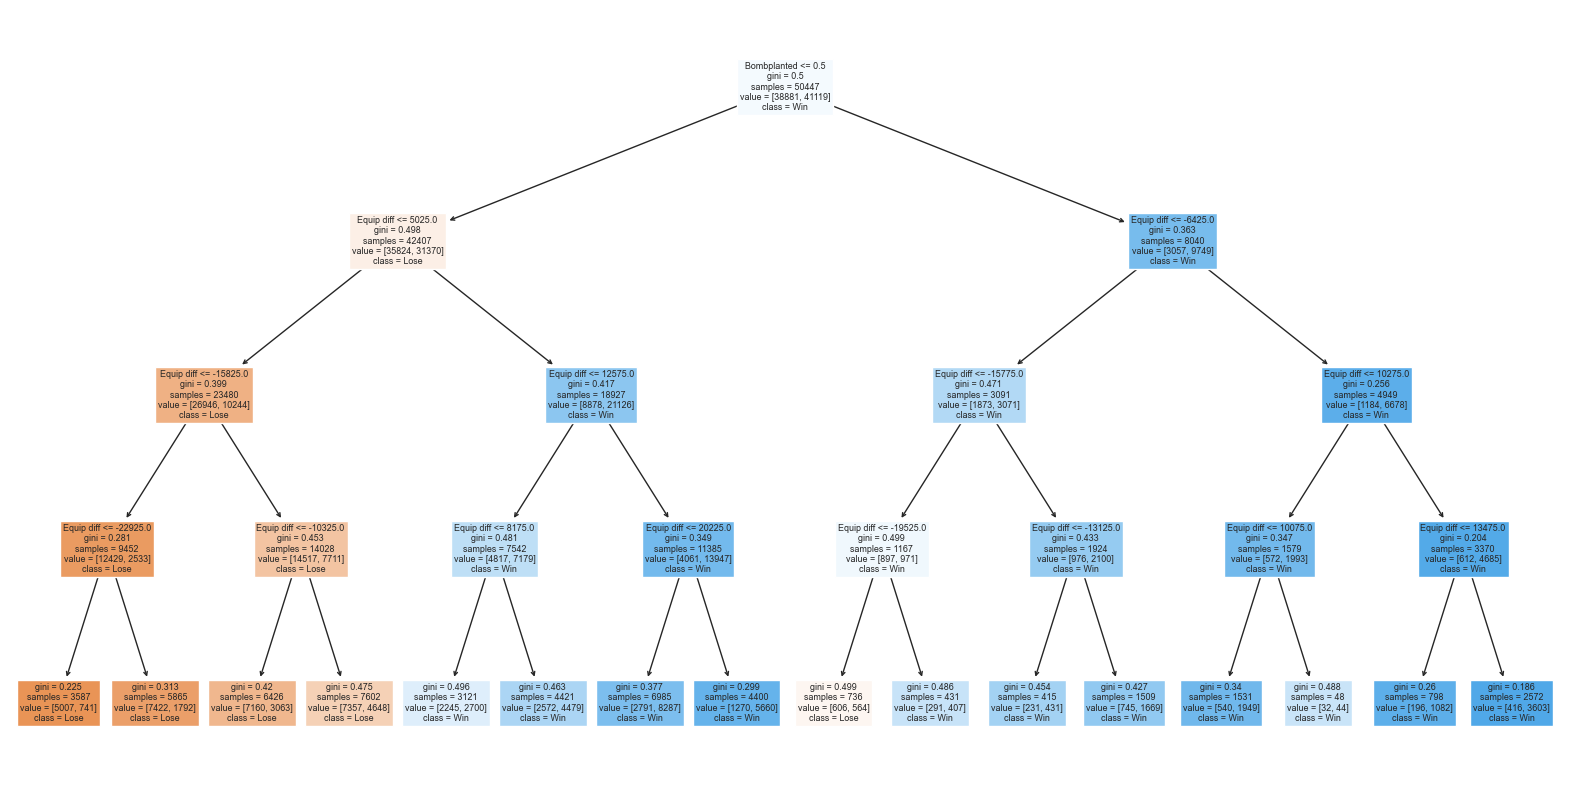

In [58]:
from sklearn.tree import plot_tree

# Plotting the first tree of the Random Forest Classifier
plt.figure(figsize=(20,10))
tree = plot_tree(rfc_t.estimators_[0], feature_names=['Equip diff','Bombplanted'], class_names=['Lose', 'Win'], filled=True)

In [59]:
target_names = ['T Lose', 'T Win']
print(classification_report(y_test_t, rfc_test_t_pred, target_names=target_names))

              precision    recall  f1-score   support

      T Lose       0.61      0.78      0.68      9644
       T Win       0.72      0.54      0.61     10356

    accuracy                           0.65     20000
   macro avg       0.66      0.66      0.65     20000
weighted avg       0.67      0.65      0.65     20000



### Precision: 
Out of all the rounds where the model predicted a win, only 72% actually did.

### Recall: 
Out of all the rounds which are actually won, the model predicted this outcome correctly for only 54% of the time.

### f1-score
We got a value of 0.65

## Remarks

The model is good for predicting Counter Terrorist side but when it comes to the Terrorist side, but it only predicted 54% of all the rounds won correctly, which is not a good value.

## 2) Logisitic Regression


## Counter Terrorist

In [60]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train.values.ravel())
logreg_pred = logreg.predict(X_test)

print("Logistic Regression \tTrain Dataset")
print("Accuracy \t:", logreg.score(X_train, y_train.values.ravel()))
print()

print("Logistic REgression \tTest Dataset")
print("Accuracy \t:", logreg.score(X_test, y_test))
print()

Logistic Regression 	Train Dataset
Accuracy 	: 0.7074

Logistic REgression 	Test Dataset
Accuracy 	: 0.7031



## Terrorist

In [61]:
logreg_t = LogisticRegression(random_state=16)
logreg_t.fit(X_train_t, y_train_t.values.ravel())
logreg_t_pred = logreg_t.predict(X_test_t)

print("Logistic Regression \tTrain Dataset")
print("Accuracy \t:", logreg_t.score(X_train_t, y_train_t.values.ravel()))
print()

print("Logistic REgression \tTest Dataset")
print("Accuracy \t:", logreg_t.score(X_test_t, y_test_t))
print()

Logistic Regression 	Train Dataset
Accuracy 	: 0.706025

Logistic REgression 	Test Dataset
Accuracy 	: 0.7086



 ## 2.1 Visualisation and model evaluation with Confusion Matrix 

## Counter Terrorist

Text(0.5, 427.9555555555555, 'Predicted label')

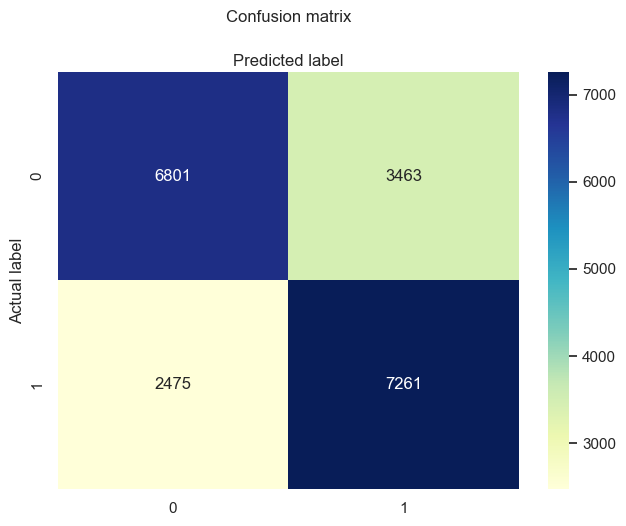

In [62]:
from sklearn import metrics
from sklearn.metrics import classification_report

cnf_matrix = metrics.confusion_matrix(y_test, logreg_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [63]:
target_names = ['CT Lose', 'CT Win']
print(classification_report(y_test, logreg_pred, target_names=target_names))

              precision    recall  f1-score   support

     CT Lose       0.73      0.66      0.70     10264
      CT Win       0.68      0.75      0.71      9736

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.70     20000
weighted avg       0.71      0.70      0.70     20000



### Precision: 
Out of all the rounds where the model predicted a win, only 68% actually did.

### Recall: 
Out of all the rounds which are actually won, the model predicted this outcome correctly for 75% of the time.

### f1-score
We got a value of 0.71, which shows the accuracy of the model in predicting whether the round is won 

## Terrorist

Text(0.5, 427.9555555555555, 'Predicted label')

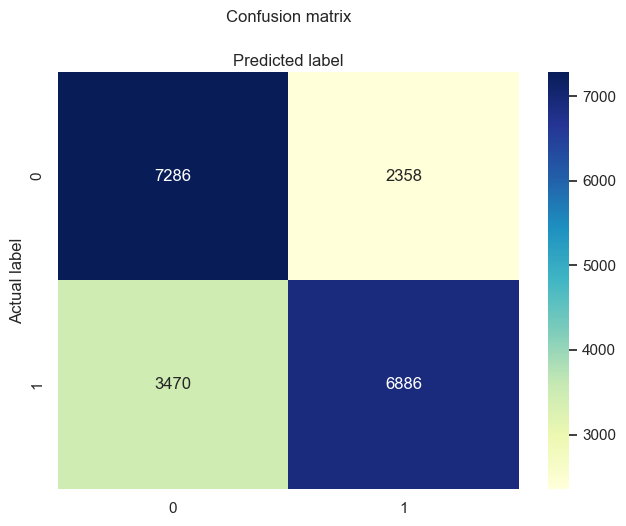

In [64]:
cnf_matrix = metrics.confusion_matrix(y_test_t, logreg_t_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [65]:
target_names = ['T Lose', 'T Win']
print(classification_report(y_test_t, logreg_t_pred, target_names=target_names))

              precision    recall  f1-score   support

      T Lose       0.68      0.76      0.71      9644
       T Win       0.74      0.66      0.70     10356

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000



### Precision: 
Out of all the rounds where the model predicted a win, only 74% actually did.

### Recall:
Out of all the rounds which are actually won, the model predicted this outcome correctly for 66% of the time.

### f1-score
We got a value of 0.71, which shows the accuracy of the model in predicting whether the round is won 

## 2.2 Visualisation and model evaulation with ROC Curve

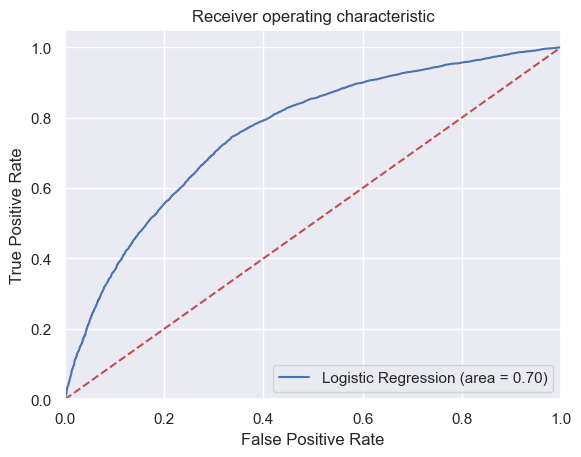

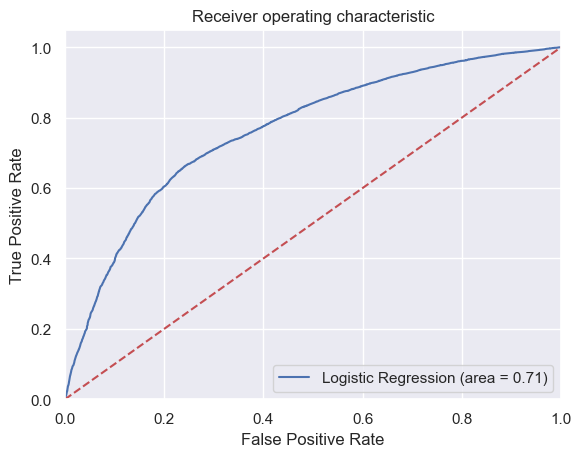

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

logit_roc_auc_t = roc_auc_score(y_test_t, logreg.predict(X_test_t))
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, logreg.predict_proba(X_test_t)[:,1])
plt.figure()
plt.plot(fpr_t, tpr_t, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_t)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

    The receiver operating characteristic (ROC) curve is a common tool used with binary classifiers such as this case. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). As we can see the area under the curve (AUC) is 0.71. It is equivalent to the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance

## 3) K-nearest-neighbour

## Counter Terrorist

In [67]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=60, weights='uniform')
knn.fit(X_train, y_train.values.ravel())
knn_pred = knn.predict(X_test)

print("K-Nearest Neighbors \tTrain Dataset")
print("Accuracy \t:", knn.score(X_train, y_train))

print("K-Nearest Neighbors \tTest Dataset")
print("Accuracy \t:", knn.score(X_test, y_test))

acc_knn = knn.score(X_test, y_test)

K-Nearest Neighbors 	Train Dataset
Accuracy 	: 0.7160875
K-Nearest Neighbors 	Test Dataset
Accuracy 	: 0.70365


## Terrorist

In [68]:
knn_t = KNeighborsClassifier(n_neighbors=60, weights='uniform')
knn_t.fit(X_train_t, y_train_t.values.ravel())
knn_t_pred = knn_t.predict(X_test_t)

print("K-Nearest Neighbors \tTrain Dataset")
print("Accuracy \t:", knn_t.score(X_train_t, y_train_t))

print("K-Nearest Neighbors \tTest Dataset")
print("Accuracy \t:", knn_t.score(X_test_t, y_test_t))

acc_knn_t = knn_t.score(X_test_t, y_test_t)

K-Nearest Neighbors 	Train Dataset
Accuracy 	: 0.7133375
K-Nearest Neighbors 	Test Dataset
Accuracy 	: 0.7095


## 3.1) Visualisation and model evaluation with Confusion Matrix

## Counter Terrorist

Text(0.5, 427.9555555555555, 'Predicted label')

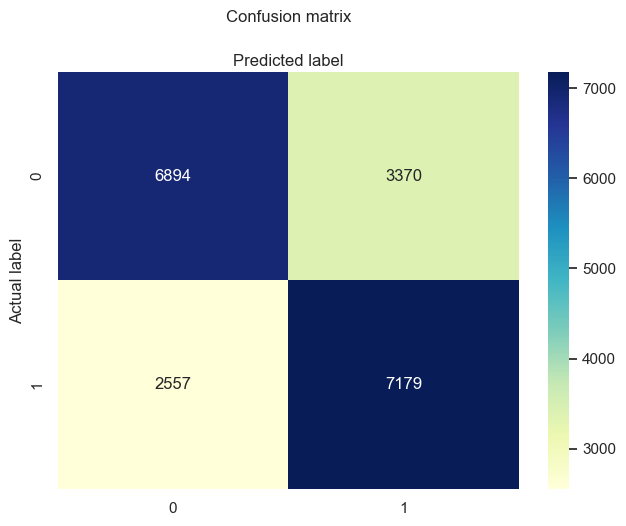

In [69]:
cnf_matrix = metrics.confusion_matrix(y_test, knn_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [70]:
target_names = ['CT Lose', 'CT Win']
print(classification_report(y_test, knn_pred, target_names=target_names))

              precision    recall  f1-score   support

     CT Lose       0.73      0.67      0.70     10264
      CT Win       0.68      0.74      0.71      9736

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.71      0.70      0.70     20000



### Precision: 
Out of all the rounds where the model predicted a win, only 0.68% actually did.

### Recall: 
Out of all the rounds which are actually won, the model predicted this outcome correctly for 74% of the time.

### f1-score
We got a value of 0.70, which shows the accuracy of the model in predicting whether the round is won 

## Terrorist

Text(0.5, 427.9555555555555, 'Predicted label')

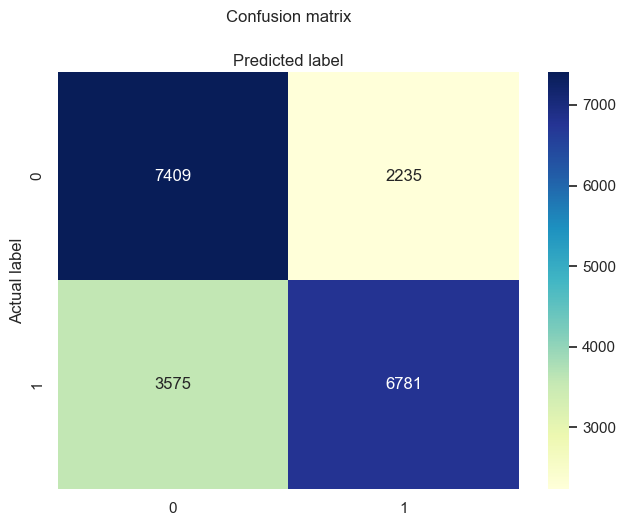

In [71]:
cnf_matrix = metrics.confusion_matrix(y_test_t, knn_t_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [72]:
target_names = ['T Lose', 'T Win']
print(classification_report(y_test_t, knn_t_pred, target_names=target_names))

              precision    recall  f1-score   support

      T Lose       0.67      0.77      0.72      9644
       T Win       0.75      0.65      0.70     10356

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000



### Precision: 
Out of all the rounds where the model predicted a win, only 75% actually did.

### Recall: 
Out of all the rounds which are actually won, the model predicted this outcome correctly for 0.65% of the time.

### f1-score
We got a value of 0.71, which shows the accuracy of the model in predicting whether the round is won 

## 3.2) Visualisation and model evaulation with Cross Validation

done


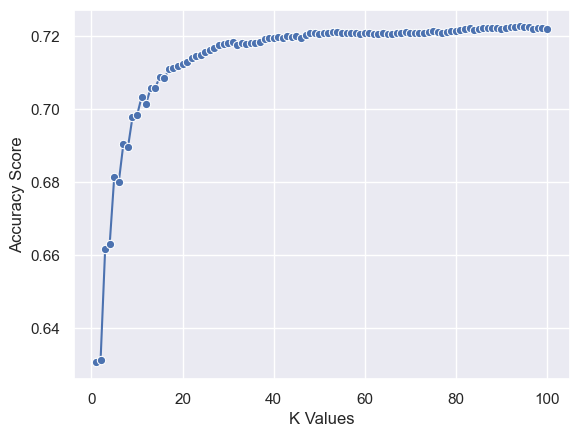

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

k_values = [i for i in range (1,101)]
scores = []

scaler = StandardScaler()
eq_diff_ct = scaler.fit_transform(eq_diff_ct)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, eq_diff_ct, side_win_ct.values.ravel(), cv=5)
    scores.append(np.mean(score))
    
sb.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
print("done")

done


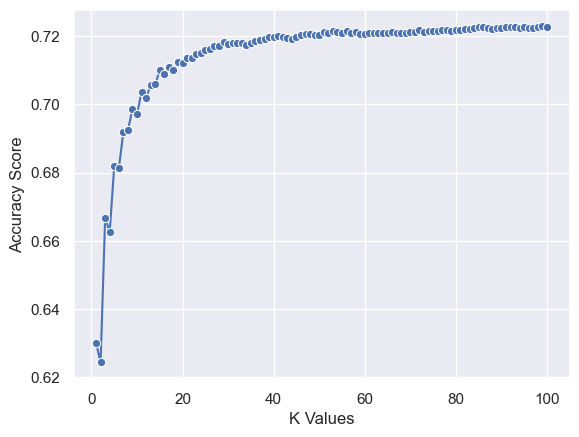

In [74]:
k_values = [i for i in range (1,101)]
scores = []

scaler = StandardScaler()
eq_diff_t = scaler.fit_transform(eq_diff_t)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, eq_diff_t, side_win_t.values.ravel(), cv=5)
    scores.append(np.mean(score))
    
sb.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
print("done")

###### We can see from the charts that as k (n_neighbours) increases, the accuracy score increases, but it starts plateauing when k reaches 50+. generally a higher k value gives better accuracy. The model used uses 60 n_neighbours which gives an Accuracy score of 71%.

# Conclusion

In [ ]:
accuracy_ct = []
accuracy_t = []
accuracy_ct = list(( acc_rfc , logreg.score(X_test, y_test), acc_knn))
accuracy_t = list(( rfc_t.score(X_test_t, y_test_t.values.ravel()) , logreg_t.score(X_test_t, y_test_t), acc_knn_t))
models = ['RFC','LR','KNN']
results = pd.DataFrame({'Model': models,
                       'CT acc': accuracy_ct,
                       'T acc': accuracy_t})
results.head()

There is a correlation between Equipment value difference and whether you win the round and between whether bomb is planted and whether you win the round. Overall, the Random Forest Classifier is a better model in predicting whether the round is won.

___